In [1]:
import json
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

import warnings
warnings.simplefilter('ignore')

%pylab inline
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'retina' 

#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 11,9

Populating the interactive namespace from numpy and matplotlib


In [2]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import words

In [3]:
# список тем книг
subj_list = ['children', 'fantasy','medicine', 'music','mystery and detective stories', 
             'recipes', 'religion', 'romance', 'science','science fiction']



In [4]:
# посмотрим на все символы, что встречаются в названиях
letter_dict = {}

for i in subj_list:
    with open(i+'.json', 'r', encoding='utf-8') as fh: #открываем файл на чтение
        data = json.load(fh)        

    for j in range(len(data['works'])):
        letter_data = data['works'][j]['title'].lower()
        #letter_data.append(['works'][j]['title'].lower()) # название
          
        for elem in letter_data: # собираем все известные символы, их число
            letter_dict[elem] = letter_dict.get(elem, 0) + 1
            #letter_list.append(elem)

letter_dict.keys() # все возможные символы, которые встречаются в названиях

dict_keys(['a', 'l', 'i', 'c', 'e', "'", 's', ' ', 'd', 'v', 'n', 't', 'u', 'r', 'w', 'o', 'h', 'p', 'y', 'f', 'm', 'z', 'g', 'ó', 'í', '(', '1', '9', '7', ')', 'j', 'b', '-', 'k', '8', '4', 'é', '?', 'ù', '3', ',', '5', '0', 'ç', 'ã', 'ñ', 'x', '!', 'q', 'ʹ', '.', 'ḳ', 'ō', 'ū', '&', 'ĭ', '︠', '︡', 'á', 'ä', 'ï', '2', 'ś', 'ẏ', 'ā', 'ỏ', 'đ', 'ậ', 'ề', 'ả', 'ệ', 'ă', 'à', 'ụ', 'ẻ', '/', '6', 'š', 'ʻ', 'è', '̂', ':', 'č', 'ł', 'ö', 'ü', 'ʼ', 'ī', 'ṭ', 'ṃ', 'ṅ', '=', '+', '#', '[', ']', '$', 'â', '̥', 'ṇ', 'ø', 'ı', 'ş', 'ḷ', '͡', 'ž', 'ě', 'ț', 'û', 'ú', '̜', 'œ', '̄', 'ǣ', 'æ', '̇', 'ê', 'ē', '"', 'ë', 'ữ', 'å', '¡', 'ė', 'ṿ', 'ą', 'ż', 'ń', 'ť', 'ḍ', 'ę', 'ô', 'ộ', 'ơ', 'ḣ', 'ʺ', 'ŭ', 'ć', 'ŏ', 'ğ', 'ḥ', 'ǧ', 'ș', '*', '̤', 'ġ', '̲', 'ṣ', '̧', 'ő', 'ư', 'ò', '́', '̋', 'ʾ', 'ṛ', 'క', 'ొ', 'త', '్', 'ప', 'ల', 'ి', 'ర', 'డ', 'స', 'ె', 'ం', 'బ', 'ు', 'చ', 'õ', 'ở', 'ớ', 'ẓ', 'î', 'ự', 'ạ', '̆', '℗', '®', '\r', '\n', 'ß', 'ố', '’', '%', '_', ';', '~', 'ǐ', '•', '‘', '—', 'ừ', 'ọ', '̨', 'ř

Ключи словаря показывают, что в библиотеке множество книг на разных языках мира. Есть научные книги, 
также мешают спецсимволы, знаки препинания.

Посмотрим, как распределены символы, чтобы понять, какой язык преобладает.

In [5]:
letter_hist_dict ={'Symbols':list(letter_dict.keys()), 'Value':list(letter_dict.values())}

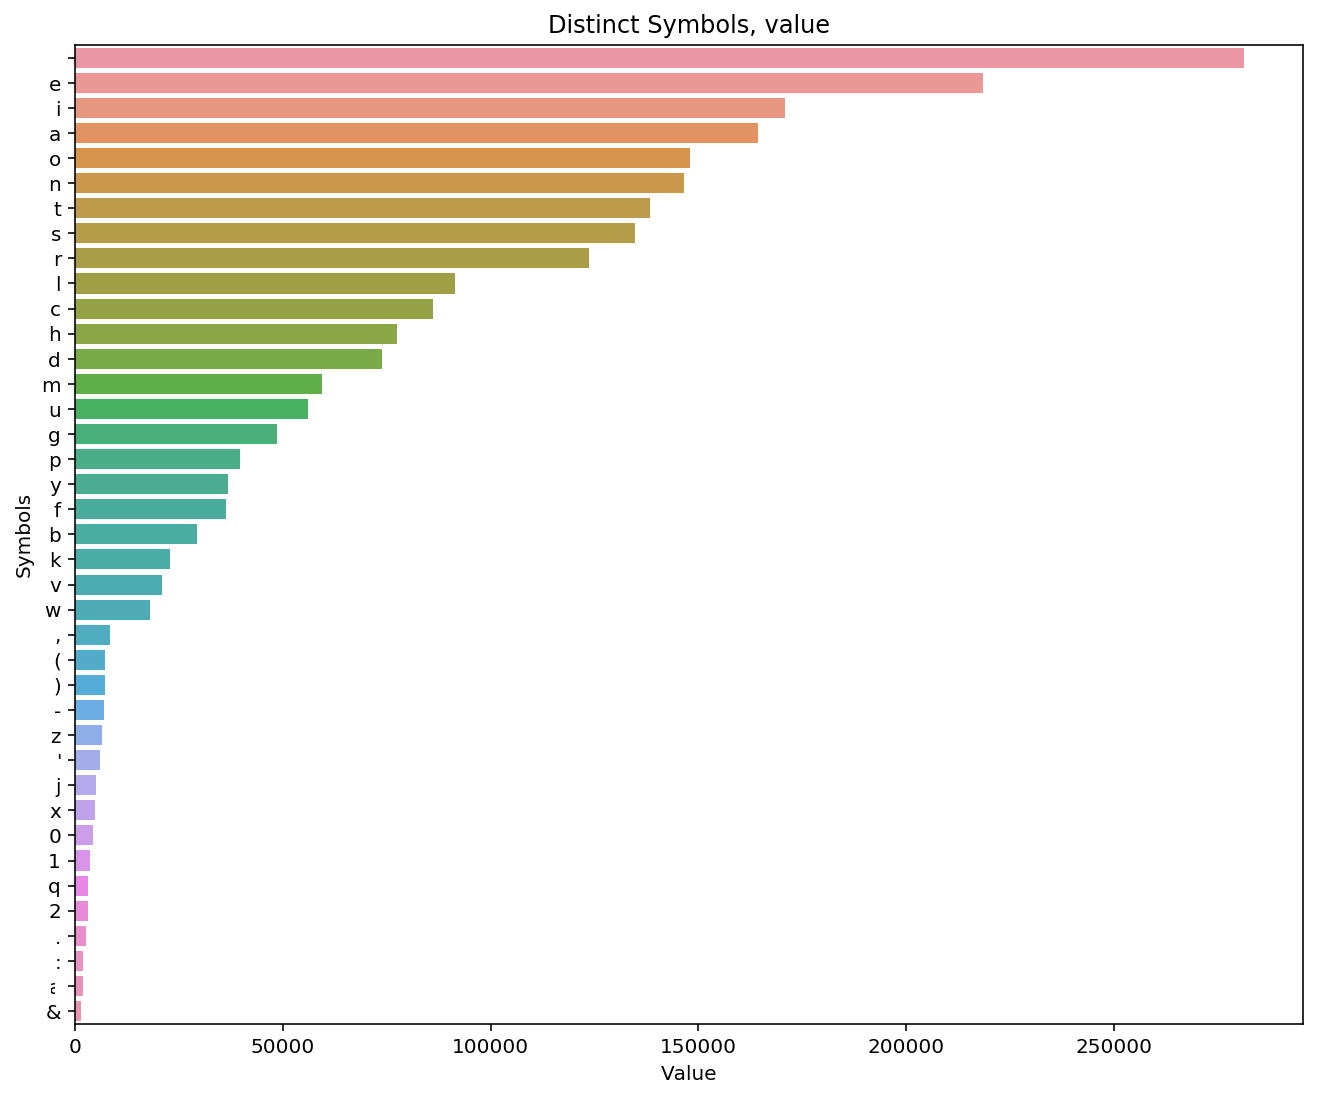

In [7]:
sm_df = pd.DataFrame(letter_hist_dict)
sm_df.sort_values(by = 'Value', ascending= False, inplace= True)
sm_val = sns.barplot(x='Value',y='Symbols',data=sm_df[sm_df.Value>1400])
sm_val.set_title('Distinct Symbols, value')
fig = sm_val.get_figure()
fig.savefig('Distinct Symbols, value', dpi = 300, bbox_inches='tight')
print();

Это латинские символы, постараемся предопределенными функциями оставить книги с названиями, в которых 
есть хотя бы одно латинское слово.

In [8]:
# список символов, убираем для лучшей обработки текта
sm = [ "'", ',', '?', '-', '.', "(", ')', '&', ':', '/', '=', 'ʻ',  'ʹ',  'ʼ' , ';', '!', 
 '"',  '*',  '_', '#', '[', ']', '%',  '<', '>',  '|',  '®', 'ʺ', '©', '\r', '\n', 
 '℗',  '’', '~', '•', '‘', '—',  '–', '@', '\xa0',  '™', '{', '}', '\t', '\\', '…', '“', '”','  ','   ']

#расширим список стоп-слов
## встречаются буквы по отдельности (окочания после апострофа и тп), возможно ошибки написания
mystopwords = set(stopwords.words('english') + ['a', 'b', 'c', 'd', 'e', 'f', 'j', 'h', 
           'g', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 
           's', 't', 'u', 'v', 'w', 'x', 'y', 'z']) 

eng_let = ['a', 'b', 'c', 'd', 'e', 'f', 'j', 'h', 'i', 
           'g', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 
           's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ' ']

In [9]:
lemm = WordNetLemmatizer()
def tokenize(x):
    article = re.compile(u'[a-z]+')    
    return article.findall(x)

def stop_words(x):
    return [token for token in x if not token in mystopwords]

def lemma(x):
    return [lemm.lemmatize(token) for token in x ]

In [10]:
from nltk.corpus import words as nltk_words
dictionary = dict.fromkeys(nltk_words.words(), None)

def is_english_word(word):   
    try:
        x = dictionary[word]
        return True
    except KeyError:
        return False

In [11]:
def del_symb(text, symb):
    clear_text = text
    for j in range(0,len(symb)):
        clear_text = clear_text.replace(symb[j],' ')
    return clear_text

In [12]:
def lang_title(title):
    for elem in title:
        if elem not in eng_let:
            title = 'not_english'
            break
        else: title
    return title    

In [13]:
# собираем данные из json в табличную форму
book_list = []
letter_dict = {}
for i in subj_list:
    print(i)
    with open(i+'.json', 'r', encoding='utf-8') as fh: #открываем файл на чтение
        data = json.load(fh)        

    for j in range(len(data['works'])):

        book_data = {}
        words = []
        eng_title = 0
        
        book_data['cover_id'] = data['works'][j]['cover_id']# номер обложки
        book_data['title'] = del_symb(data['works'][j]['title'].lower(), sm) # название

        # чистим от названий с символами, где нет a-z
        # оставляем названия, где есть хотя бы одно английское слово
        if lang_title(book_data['title']) != 'not_english':
            words = lemma(tokenize(book_data['title']))
            for w in words:
                if is_english_word(w) == True:
                    eng_title +=1

  
        for elem in data['works'][j]['subject']: # темы книги
            if elem.lower() in subj_list:
                book_data[elem.lower()] = int(1)
                book_data[elem.lower()+'txt'] = elem.lower() # удобно заполненные колонки для boxplot 
        print(book_data)
        if eng_title > 0:
            book_list.append(book_data)        

children
{'cover_id': 575546, 'title': 'alice s adventures in wonderland', 'fantasy': 1, 'fantasytxt': 'fantasy', 'children': 1, 'childrentxt': 'children'}
{'cover_id': 1981419, 'title': 'the personal history of david copperfield', 'children': 1, 'childrentxt': 'children'}
{'cover_id': 905279, 'title': 'american notes', 'children': 1, 'childrentxt': 'children'}
{'cover_id': 1321813, 'title': 'wizard of oz', 'children': 1, 'childrentxt': 'children'}
{'cover_id': 2964863, 'title': 'the turn of the screw', 'children': 1, 'childrentxt': 'children'}
{'cover_id': 311182, 'title': 'a child s garden of verses', 'children': 1, 'childrentxt': 'children'}
{'cover_id': 5407253, 'title': 'constitución política 1917 ', 'children': 1, 'childrentxt': 'children'}
{'cover_id': 103374, 'title': 'jude the obscure', 'children': 1, 'childrentxt': 'children'}
{'cover_id': None, 'title': 'foreign assistance', 'children': 1, 'childrentxt': 'children'}
{'cover_id': 5898554, 'title': 'aunt jo s scrap bag', 'chil

{'cover_id': 1875017, 'title': 'gimme five ', 'children': 1, 'childrentxt': 'children'}
{'cover_id': None, 'title': 'vietnam s children in a changing world', 'children': 1, 'childrentxt': 'children'}
{'cover_id': 2290138, 'title': 'making a difference', 'children': 1, 'childrentxt': 'children'}
{'cover_id': 1640284, 'title': 'jesse', 'children': 1, 'childrentxt': 'children'}
{'cover_id': 5365200, 'title': 'the standard of the best interests of the child', 'children': 1, 'childrentxt': 'children'}
{'cover_id': 859008, 'title': 'better than peanut butter and jelly', 'children': 1, 'childrentxt': 'children'}
{'cover_id': None, 'title': 'what to teach your child', 'children': 1, 'childrentxt': 'children'}
{'cover_id': 860271, 'title': 'the adventure of christmas', 'children': 1, 'childrentxt': 'children'}
{'cover_id': 1173988, 'title': 'children and the law in a nutshell', 'children': 1, 'childrentxt': 'children'}
{'cover_id': 1695718, 'title': 'over the highest mountains', 'children': 1, 

{'cover_id': None, 'title': 'gendai no kodomo', 'children': 1, 'childrentxt': 'children'}
{'cover_id': None, 'title': 'mu shang', 'children': 1, 'childrentxt': 'children'}
{'cover_id': None, 'title': 'empirical analysis of determinants distribution and dynamics of poverty', 'children': 1, 'childrentxt': 'children'}
{'cover_id': None, 'title': 'shōgen tsumetai sokoku', 'children': 1, 'childrentxt': 'children'}
{'cover_id': 5357244, 'title': 'quinto año de vigencia de la ley orgánica para la protección del niño y del adolescente', 'children': 1, 'childrentxt': 'children'}
{'cover_id': 5353787, 'title': 'gakkō no monsutā', 'children': 1, 'childrentxt': 'children'}
{'cover_id': None, 'title': 'baby bites', 'children': 1, 'childrentxt': 'children'}
{'cover_id': None, 'title': 'a historical sociology of childhood', 'children': 1, 'childrentxt': 'children'}
{'cover_id': None, 'title': 'moi︠a︡ pobeda', 'children': 1, 'childrentxt': 'children'}
{'cover_id': None, 'title': 'ṿa yoled', 'children'

{'cover_id': None, 'title': 'the strange fate of kitty easton', 'children': 1, 'childrentxt': 'children'}
{'cover_id': None, 'title': 'children of the changing south', 'children': 1, 'childrentxt': 'children'}
{'cover_id': None, 'title': '50 life skills to ensure kids stay in school off drugs and out of trouble', 'children': 1, 'childrentxt': 'children'}
{'cover_id': None, 'title': 'teaching oral language', 'children': 1, 'childrentxt': 'children'}
{'cover_id': None, 'title': 'planning a wic research agenda', 'children': 1, 'childrentxt': 'children'}
{'cover_id': None, 'title': 'the complete idiot s guide to the best family destinations', 'children': 1, 'childrentxt': 'children'}
{'cover_id': None, 'title': 'murder medicine and motherhood', 'children': 1, 'childrentxt': 'children'}
{'cover_id': None, 'title': 'okinawa sengo kodomo seikatsushi', 'children': 1, 'childrentxt': 'children'}
{'cover_id': None, 'title': 'child fatality review quick reference', 'children': 1, 'childrentxt': 'c

{'cover_id': 478374, 'title': 'thraxas', 'fantasy': 1, 'fantasytxt': 'fantasy'}
{'cover_id': None, 'title': 'volshebnik izumrudnogo goroda', 'fantasy': 1, 'fantasytxt': 'fantasy'}
{'cover_id': 210959, 'title': 'the greenstone grail', 'fantasy': 1, 'fantasytxt': 'fantasy'}
{'cover_id': 209769, 'title': 'a caress of twilight', 'fantasy': 1, 'fantasytxt': 'fantasy'}
{'cover_id': 506426, 'title': 'emperor and clown', 'fantasy': 1, 'fantasytxt': 'fantasy'}
{'cover_id': 38893, 'title': 'the serpent bride darkglass mountain book 1 ', 'fantasy': 1, 'fantasytxt': 'fantasy'}
{'cover_id': 221068, 'title': 'a distant tomorrow world of hetar ', 'romance': 1, 'romancetxt': 'romance', 'fantasy': 1, 'fantasytxt': 'fantasy'}
{'cover_id': 1119132, 'title': 'dingo', 'fantasy': 1, 'fantasytxt': 'fantasy'}
{'cover_id': 6405608, 'title': 'elegy beach', 'fantasy': 1, 'fantasytxt': 'fantasy'}
{'cover_id': 169326, 'title': 'the sword and the flame', 'fantasy': 1, 'fantasytxt': 'fantasy'}
{'cover_id': 27056, 't

{'cover_id': 886462, 'title': 'ulli  marquand warhammer ', 'fantasy': 1, 'fantasytxt': 'fantasy'}
{'cover_id': 1713872, 'title': 'grafenveer vol 1', 'fantasy': 1, 'fantasytxt': 'fantasy'}
{'cover_id': 535957, 'title': 'punisher max vol 2', 'fantasy': 1, 'fantasytxt': 'fantasy'}
{'cover_id': 764459, 'title': 'the sons of maeve trilogy', 'fantasy': 1, 'fantasytxt': 'fantasy'}
{'cover_id': None, 'title': 'hammer of the gods volume 2', 'fantasy': 1, 'fantasytxt': 'fantasy'}
{'cover_id': 707390, 'title': 'sci fi womanthology ackermanthologies ', 'fantasy': 1, 'fantasytxt': 'fantasy', 'science fiction': 1, 'science fictiontxt': 'science fiction'}
{'cover_id': 1464766, 'title': 'incredible hulk', 'fantasy': 1, 'fantasytxt': 'fantasy'}
{'cover_id': 1870723, 'title': 'twilight crossings ii', 'fantasy': 1, 'fantasytxt': 'fantasy'}
{'cover_id': 524111, 'title': 'emerald magic', 'fantasy': 1, 'fantasytxt': 'fantasy'}
{'cover_id': 758641, 'title': 'pretear vol 2', 'fantasy': 1, 'fantasytxt': 'fanta

{'cover_id': 7428993, 'title': 'the familiars', 'fantasy': 1, 'fantasytxt': 'fantasy'}
{'cover_id': 552866, 'title': 'alice in wonderland', 'fantasy': 1, 'fantasytxt': 'fantasy'}
{'cover_id': None, 'title': 'shadow spell', 'fantasy': 1, 'fantasytxt': 'fantasy'}
{'cover_id': 876975, 'title': 'alice in wonderland', 'fantasy': 1, 'fantasytxt': 'fantasy'}
{'cover_id': None, 'title': 'river rescue', 'fantasy': 1, 'fantasytxt': 'fantasy'}
{'cover_id': None, 'title': 'peter pan', 'fantasy': 1, 'fantasytxt': 'fantasy'}
{'cover_id': 289522, 'title': 'the crystal planet', 'fantasy': 1, 'fantasytxt': 'fantasy'}
{'cover_id': None, 'title': 'truancy city', 'fantasy': 1, 'fantasytxt': 'fantasy'}
{'cover_id': 7073874, 'title': 'the goblin war', 'fantasy': 1, 'fantasytxt': 'fantasy'}
{'cover_id': None, 'title': 'liar s moon', 'mystery and detective stories': 1, 'mystery and detective storiestxt': 'mystery and detective stories', 'fantasy': 1, 'fantasytxt': 'fantasy'}
{'cover_id': None, 'title': 'daugh

{'cover_id': 584045, 'title': 'the internet and health care', 'medicine': 1, 'medicinetxt': 'medicine'}
{'cover_id': 3145432, 'title': 'dictionnaire vidal 2001 french physician s desk reference ', 'medicine': 1, 'medicinetxt': 'medicine'}
{'cover_id': None, 'title': 'cecil textbook of medicine single volume 22nd edition and nelson textbook of pediatrics 17th edition package', 'medicine': 1, 'medicinetxt': 'medicine'}
{'cover_id': 5389909, 'title': 'manual of vascular diseases field guide series ', 'medicine': 1, 'medicinetxt': 'medicine'}
{'cover_id': 5210830, 'title': 'healthcare interpreting', 'medicine': 1, 'medicinetxt': 'medicine'}
{'cover_id': 4819158, 'title': 'introduction to reference sources in the health sciences', 'medicine': 1, 'medicinetxt': 'medicine'}
{'cover_id': 2088404, 'title': 'high tech medicine ', 'medicine': 1, 'medicinetxt': 'medicine'}
{'cover_id': None, 'title': 'problemy formirovanii︠a︡ zdorovogo obraza zhizni uchashcheĭsi︠a︡ molodezhi i deteĭ doshkol nogo v

{'cover_id': None, 'title': 'mitral valve repair', 'medicine': 1, 'medicinetxt': 'medicine'}
{'cover_id': None, 'title': 'imaging atlas of the pelvic floor and anorectal diseases', 'medicine': 1, 'medicinetxt': 'medicine'}
{'cover_id': None, 'title': 'active implants and scaffolds for tissue regeneration', 'medicine': 1, 'medicinetxt': 'medicine'}
{'cover_id': None, 'title': 'musculoskeletal diseases 2009 2012', 'medicine': 1, 'medicinetxt': 'medicine'}
{'cover_id': None, 'title': 'atlas of thyroid lesions', 'medicine': 1, 'medicinetxt': 'medicine'}
{'cover_id': None, 'title': 'physiologie pathologie et thérapie de la reproduction chez l humain', 'medicine': 1, 'medicinetxt': 'medicine'}
{'cover_id': None, 'title': 'fundamentals of space medicine', 'medicine': 1, 'medicinetxt': 'medicine'}
{'cover_id': None, 'title': 'perioperative medicine', 'medicine': 1, 'medicinetxt': 'medicine'}
{'cover_id': None, 'title': 'minimally invasive surgery of the foot and ankle', 'medicine': 1, 'medicin

{'cover_id': None, 'title': 'contribuição bantu na música popular brasileira', 'music': 1, 'musictxt': 'music'}
{'cover_id': 125535, 'title': 'who needs classical music ', 'music': 1, 'musictxt': 'music'}
{'cover_id': None, 'title': 'musiker und monarchen in meiningen 1680 bis 1763', 'music': 1, 'musictxt': 'music'}
{'cover_id': None, 'title': 'lagermusik e resistenza viktor ullmann e gideon klein a theresienstadt', 'music': 1, 'musictxt': 'music'}
{'cover_id': 3842140, 'title': 'o mistério do samba', 'music': 1, 'musictxt': 'music'}
{'cover_id': 746911, 'title': 'puccini without excuses', 'music': 1, 'musictxt': 'music'}
{'cover_id': 168087, 'title': 'is tiny dancer really elton s little john ', 'music': 1, 'musictxt': 'music'}
{'cover_id': None, 'title': 'harmonious triads', 'music': 1, 'musictxt': 'music'}
{'cover_id': None, 'title': 'mozart  beethoven', 'music': 1, 'musictxt': 'music'}
{'cover_id': 6282100, 'title': 'the history of jazz', 'music': 1, 'musictxt': 'music'}
{'cover_id

{'cover_id': None, 'title': 'tavattiru caṅkaratās cuvāmikaḷin̲ nāṭakaṅkaḷil icaikkūr̲ukaḷ', 'music': 1, 'musictxt': 'music'}
{'cover_id': None, 'title': 'ādivāsī ṭhākara āṇi tyāñcī lokagīte', 'music': 1, 'musictxt': 'music'}
{'cover_id': None, 'title': 'le manoir de bel ebat et la musique française autour de claude debussy', 'music': 1, 'musictxt': 'music'}
{'cover_id': None, 'title': 'lexikon würzburger hofmusiker vom 16 bis zum 19 jahrhundert', 'music': 1, 'musictxt': 'music'}
{'cover_id': None, 'title': 'la sociedad filarmónica de quito', 'music': 1, 'musictxt': 'music'}
{'cover_id': None, 'title': 'bhāratīya sāṅgītika jagata meṃ vārāṇasī kā yogadāna', 'music': 1, 'musictxt': 'music'}
{'cover_id': None, 'title': 'pianistas clásicos de guatemala en el siglo xx', 'music': 1, 'musictxt': 'music'}
{'cover_id': 4316773, 'title': 'visiones sonoras', 'music': 1, 'musictxt': 'music'}
{'cover_id': None, 'title': 'prācīna bhārata meṃ saṅgīta', 'music': 1, 'musictxt': 'music'}
{'cover_id': Non

{'cover_id': None, 'title': 'listen 5e brief cloth  3 cd set to accompany listen 5e brief', 'music': 1, 'musictxt': 'music'}
{'cover_id': 1376174, 'title': 'an introduction to his keyboard works alfred cd edition ', 'music': 1, 'musictxt': 'music'}
{'cover_id': 1330075, 'title': 'advanced guitar soloing', 'music': 1, 'musictxt': 'music'}
{'cover_id': 158484, 'title': 'ipod therefore i am', 'music': 1, 'musictxt': 'music'}
{'cover_id': None, 'title': 'los musicos de bremen', 'music': 1, 'musictxt': 'music'}
{'cover_id': 3339524, 'title': 'concerto with cd audio ', 'music': 1, 'musictxt': 'music'}
{'cover_id': 1416134, 'title': 'selections from chicago', 'music': 1, 'musictxt': 'music'}
{'cover_id': 3260809, 'title': 'encyclopedia of mechanical m i ', 'music': 1, 'musictxt': 'music'}
{'cover_id': 2030521, 'title': 'the tarantino collection pvg ', 'music': 1, 'musictxt': 'music'}
{'cover_id': 500649, 'title': 'to hell and back', 'music': 1, 'musictxt': 'music'}
{'cover_id': 2568911, 'titl

{'cover_id': None, 'title': 'musiques et danses de cuba', 'music': 1, 'musictxt': 'music'}
{'cover_id': None, 'title': 'xin wen hua yun dong shi qi yin yue chuang jiang wang guangqi yu xi nan di qu min zu yin yue ', 'music': 1, 'musictxt': 'music'}
{'cover_id': None, 'title': 'de música e músicos', 'music': 1, 'musictxt': 'music'}
{'cover_id': None, 'title': 'the rock n roll classroom', 'music': 1, 'musictxt': 'music'}
{'cover_id': None, 'title': 'lebewohl', 'music': 1, 'musictxt': 'music'}
{'cover_id': None, 'title': 'goethe und die musik', 'music': 1, 'musictxt': 'music'}
{'cover_id': None, 'title': 'hát xả̂m', 'music': 1, 'musictxt': 'music'}
{'cover_id': None, 'title': 'melodies of the mind', 'music': 1, 'musictxt': 'music'}
{'cover_id': None, 'title': 'a questão cavalier', 'music': 1, 'musictxt': 'music'}
{'cover_id': None, 'title': 'whose spain ', 'music': 1, 'musictxt': 'music'}
{'cover_id': None, 'title': 'sonic liturgy', 'music': 1, 'musictxt': 'music'}
{'cover_id': None, 'tit

{'cover_id': None, 'title': 'the berimbau', 'music': 1, 'musictxt': 'music'}
{'cover_id': None, 'title': 'katch in chonjae ŭi yesul yŏllin yesul', 'music': 1, 'musictxt': 'music'}
{'cover_id': None, 'title': 'musique art et religion dans l entre deux guerres', 'music': 1, 'musictxt': 'music'}
{'cover_id': None, 'title': 'yi wei ren lei xue zhe shi ye zhong de maixilaifu', 'music': 1, 'musictxt': 'music'}
{'cover_id': None, 'title': 'the musician s guide to licensing music', 'music': 1, 'musictxt': 'music'}
{'cover_id': None, 'title': 'arts culture valeurs éducatives', 'music': 1, 'musictxt': 'music'}
{'cover_id': None, 'title': 'mozart und die religion', 'religion': 1, 'religiontxt': 'religion', 'music': 1, 'musictxt': 'music'}
{'cover_id': None, 'title': 'üzeyir hacıbäyov ensiklopediyası', 'music': 1, 'musictxt': 'music'}
{'cover_id': None, 'title': 'the diffusion of black gospel music in postmodern denmark', 'music': 1, 'musictxt': 'music'}
{'cover_id': None, 'title': 'america s musi

{'cover_id': None, 'title': 'music together', 'music': 1, 'musictxt': 'music'}
{'cover_id': 1323423, 'title': 'the song that never ends', 'music': 1, 'musictxt': 'music'}
{'cover_id': None, 'title': 'lift every voice', 'music': 1, 'musictxt': 'music'}
{'cover_id': 1580509, 'title': 'coco makes music', 'music': 1, 'musictxt': 'music'}
{'cover_id': 361361, 'title': 'the song shoots out of my mouth', 'music': 1, 'musictxt': 'music'}
{'cover_id': 6964137, 'title': 'zin zin zin ', 'music': 1, 'musictxt': 'music'}
{'cover_id': 7077216, 'title': 'secular devotion', 'music': 1, 'musictxt': 'music'}
{'cover_id': 4338830, 'title': 'cool careers without college for music lovers', 'music': 1, 'musictxt': 'music'}
{'cover_id': 674785, 'title': 'all music guide', 'music': 1, 'musictxt': 'music'}
{'cover_id': 6768424, 'title': 'yonder come the blues', 'music': 1, 'musictxt': 'music'}
{'cover_id': None, 'title': 'the triumph of music', 'music': 1, 'musictxt': 'music'}
{'cover_id': 226791, 'title': 'co

{'cover_id': None, 'title': 'hanging by a thread', 'mystery and detective stories': 1, 'mystery and detective storiestxt': 'mystery and detective stories'}
{'cover_id': None, 'title': 'book girl and the famished spirit', 'mystery and detective stories': 1, 'mystery and detective storiestxt': 'mystery and detective stories'}
{'cover_id': None, 'title': 'poison most vial', 'mystery and detective stories': 1, 'mystery and detective storiestxt': 'mystery and detective stories'}
{'cover_id': 233571, 'title': 'miss hildy s missing cape caper', 'mystery and detective stories': 1, 'mystery and detective storiestxt': 'mystery and detective stories'}
{'cover_id': None, 'title': 'hide and secret', 'mystery and detective stories': 1, 'mystery and detective storiestxt': 'mystery and detective stories'}
{'cover_id': None, 'title': 'social suicide', 'mystery and detective stories': 1, 'mystery and detective storiestxt': 'mystery and detective stories'}
{'cover_id': None, 'title': 'book girl and the w

{'cover_id': 6460619, 'title': 'eat tweet', 'recipes': 1, 'recipestxt': 'recipes'}
{'cover_id': 6453378, 'title': 'cooking with booze', 'recipes': 1, 'recipestxt': 'recipes'}
{'cover_id': None, 'title': 'the french women don t get fat cookbook', 'recipes': 1, 'recipestxt': 'recipes'}
{'cover_id': None, 'title': 'splenda brand recipe collection', 'recipes': 1, 'recipestxt': 'recipes'}
{'cover_id': None, 'title': 'the diabetes seafood cookbook', 'recipes': 1, 'recipestxt': 'recipes'}
{'cover_id': 6678103, 'title': 'roaming the big land', 'recipes': 1, 'recipestxt': 'recipes'}
{'cover_id': 6731474, 'title': 'the perfect match a novel ', 'recipes': 1, 'recipestxt': 'recipes'}
{'cover_id': 7026765, 'title': 'the gluten free italian cookbook', 'recipes': 1, 'recipestxt': 'recipes'}
{'cover_id': None, 'title': 'ai zheng bing ren yin shi yi ji yu shi liao miao fang', 'recipes': 1, 'recipestxt': 'recipes'}
{'cover_id': None, 'title': '$3 low calorie meals', 'recipes': 1, 'recipestxt': 'recipes'

{'cover_id': None, 'title': 'mouna mimouna achoura', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': None, 'title': 'i cristiani e l islàm in italia', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': None, 'title': 'götter auf erden', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': None, 'title': 'the tribe of witches', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': None, 'title': 'nostalgie d israël', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': None, 'title': 'po ti ni ja', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': None, 'title': 'la problematique de la philosophie de dieu', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': None, 'title': 'dazai osamu ron', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': None, 'title': 'ta n teli ktlamsitasit ways of believing ', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': None, 'title': 'le christ en guinée forestière', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': No

{'cover_id': 2366191, 'title': 'kjv holy bible reference platinum edition', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': 938495, 'title': 'morality', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': 5113543, 'title': 'santa biblia', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': 2122055, 'title': 'heaven can wait', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': 818411, 'title': 'dictionary of third world theologies', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': 1830438, 'title': 'the number four in the theosophical seal', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': None, 'title': 'framework re year 8', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': None, 'title': 'a book of mormon treasury', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': 2366151, 'title': 'kjv holy bible giant print reference gold edition', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': 958561, 'title': 'don t chew jesus ', 'religion': 1, 'rel

{'cover_id': 2481607, 'title': 'liturgies and other documents', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': 4780431, 'title': 'the catholic prayerbook', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': 1568932, 'title': 'our god reigns book  cd ', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': 1981632, 'title': 'catholic parent know how preparing your child first communion la primera comunion ', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': 4772564, 'title': 'our life in the church', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': 2555651, 'title': 'this is re 1', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': 1932527, 'title': 'life in the spirit seminar', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': 2762293, 'title': 'creed of presbyterians the', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': 2785759, 'title': 'life savors', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': None, 'title': 'women s voices', 'relig

{'cover_id': 4849520, 'title': 'the liturgy of the medieval church', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': None, 'title': 'rite of confirmation  bilingual edi', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': 2640892, 'title': 'los doce discipulos the twelve disciples', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': 1715709, 'title': 'manifest power', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': 700297, 'title': 'the illustrated bible', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': 899013, 'title': 'qur an', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': 1553938, 'title': 'preparing your catholic wedding', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': 2565531, 'title': 'summus pontifex ecclesiae 380 1534', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': 2003788, 'title': 'kjv compact ref bible magnetic closure bon bg', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': 2959007, 'title': 'champions  plus', 'r

{'cover_id': 4918864, 'title': 'en busca de nuestras huellas  tracing the way', 'science': 1, 'sciencetxt': 'science', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': 2942733, 'title': 'pocket size bible classic edition', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': 1991967, 'title': 'the quran and sayings of prophet muhammad', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': 2878282, 'title': 'hippolytus bishop of rome', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': 4897325, 'title': 'catholic social thought', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': 825466, 'title': 'offense to reason', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': 2003783, 'title': 'holy bible', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': 2932071, 'title': 'life of the spirit in the mature years', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': 463809, 'title': 'bruce  stan s pocket guide to talking with god pocket guide ', 'religion': 1, 'reli

{'cover_id': 4529009, 'title': 'bosnia the good', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': None, 'title': 'amazing facts about hinduism', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': None, 'title': 'through the bamboo window', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': 5495584, 'title': 'kinsei no autorō to shūen shakai', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': 4525599, 'title': 'ritual in narrative', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': None, 'title': 'prācīna nepālī samājamā pracalita pramukha dharmaharū', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': None, 'title': 'briznas de la memoria', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': None, 'title': 'mgr rené vilatte', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': None, 'title': 'chi ha paura del dio biblico ', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': None, 'title': 'srazhenie za tolstogo', 'religion': 1, 'religiontxt': 'rel

{'cover_id': 6958869, 'title': 'ranking faiths', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': None, 'title': 'min tai kejia zong jiao yu wen hua', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': None, 'title': 'een eiland na de reformatie', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': None, 'title': 'teoreticheskie i prikladnye issledovanii︠a︡ v religiovedenii', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': None, 'title': 'choosing honor', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': None, 'title': 'escapism', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': None, 'title': 'osmanlı belgelerinde kızılbaşlar hakkında idam ve sürgün fermanları', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': None, 'title': 'rājasthāna ke santa mahātmā', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': None, 'title': 'yao zu pan hu long quan tu teng wen hua yan jiu ', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': None, 'title': 'hām

{'cover_id': None, 'title': 'agama suku', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': 2120637, 'title': 'asian american evangelical churches', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': None, 'title': 'rawlsian explorations in religion and applied philosophy', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': None, 'title': 'ministry among the maya', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': None, 'title': 'the historical development of the bhakti movement in india', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': None, 'title': 'el clero en la segunda república', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': None, 'title': 'tesauro y diccionario de objetos asociados a ritos cultos y creencias', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': None, 'title': 'rus  rossii︠a︡', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id': None, 'title': 'bangunan suci sunda kuna', 'religion': 1, 'religiontxt': 'religion'}
{'cover_id

{'cover_id': 6598167, 'title': 'midnight rising', 'romance': 1, 'romancetxt': 'romance'}
{'cover_id': 531786, 'title': 'deadly illusions', 'romance': 1, 'romancetxt': 'romance'}
{'cover_id': 1910999, 'title': 'the wilder sisters', 'romance': 1, 'romancetxt': 'romance'}
{'cover_id': 211883, 'title': 'the hunt', 'romance': 1, 'romancetxt': 'romance'}
{'cover_id': 237557, 'title': 'amber beach', 'romance': 1, 'romancetxt': 'romance'}
{'cover_id': 2413503, 'title': 'the pajama girls of lambert square', 'romance': 1, 'romancetxt': 'romance'}
{'cover_id': 1957742, 'title': 'beyond the highland mist', 'romance': 1, 'romancetxt': 'romance'}
{'cover_id': 5086872, 'title': 'the angel', 'romance': 1, 'romancetxt': 'romance'}
{'cover_id': 45069, 'title': 'master of seduction', 'romance': 1, 'romancetxt': 'romance'}
{'cover_id': 531806, 'title': 'killing kelly', 'romance': 1, 'romancetxt': 'romance'}
{'cover_id': 2801896, 'title': 'being with him', 'romance': 1, 'romancetxt': 'romance'}
{'cover_id'

{'cover_id': 2406831, 'title': 'for the sake of his child', 'romance': 1, 'romancetxt': 'romance'}
{'cover_id': 2408911, 'title': 'one night love child', 'romance': 1, 'romancetxt': 'romance'}
{'cover_id': 6415325, 'title': 'the sicilian s ruthless marriage revenge', 'romance': 1, 'romancetxt': 'romance'}
{'cover_id': 7004988, 'title': 'after the kiss', 'romance': 1, 'romancetxt': 'romance'}
{'cover_id': 7114546, 'title': 'the billionaire boss innocent bride', 'romance': 1, 'romancetxt': 'romance'}
{'cover_id': 1471260, 'title': 'duchess in love', 'romance': 1, 'romancetxt': 'romance'}
{'cover_id': 1155231, 'title': 'the spaniard s inconvenient wife', 'romance': 1, 'romancetxt': 'romance'}
{'cover_id': 6645147, 'title': 'millionaire dad nanny needed', 'romance': 1, 'romancetxt': 'romance'}
{'cover_id': 7095801, 'title': 'delicious', 'romance': 1, 'romancetxt': 'romance'}
{'cover_id': 6394690, 'title': 'untouched', 'romance': 1, 'romancetxt': 'romance'}
{'cover_id': 6629485, 'title': 't

{'cover_id': 1416886, 'title': 'double dating with the dead', 'romance': 1, 'romancetxt': 'romance'}
{'cover_id': 6411052, 'title': 'pieces of sky', 'romance': 1, 'romancetxt': 'romance'}
{'cover_id': 273440, 'title': 'heiress for hire', 'romance': 1, 'romancetxt': 'romance'}
{'cover_id': 6408502, 'title': 'an ideal father', 'romance': 1, 'romancetxt': 'romance'}
{'cover_id': 6416713, 'title': 'the duke s new year s resolution', 'romance': 1, 'romancetxt': 'romance'}
{'cover_id': None, 'title': 'forgotten', 'romance': 1, 'romancetxt': 'romance'}
{'cover_id': 222462, 'title': 'tangled memories steeple hill love inspired suspense ', 'romance': 1, 'romancetxt': 'romance'}
{'cover_id': 505996, 'title': 'blood rose', 'romance': 1, 'romancetxt': 'romance'}
{'cover_id': 6408012, 'title': 'royal seducer', 'romance': 1, 'romancetxt': 'romance'}
{'cover_id': 2410619, 'title': 'last wolf standing', 'fantasy': 1, 'fantasytxt': 'fantasy', 'romance': 1, 'romancetxt': 'romance'}
{'cover_id': 6403813,

{'cover_id': 7361956, 'title': 'posesión', 'romance': 1, 'romancetxt': 'romance'}
{'cover_id': 290064, 'title': 'prince charming', 'romance': 1, 'romancetxt': 'romance'}
{'cover_id': 237374, 'title': 'the prince s bride', 'romance': 1, 'romancetxt': 'romance'}
{'cover_id': 8076200, 'title': 'who needs mistletoe ', 'romance': 1, 'romancetxt': 'romance'}
{'cover_id': 641099, 'title': 'the trouble with harry', 'romance': 1, 'romancetxt': 'romance'}
{'cover_id': 8074090, 'title': 'es que no lo deseas', 'romance': 1, 'romancetxt': 'romance'}
{'cover_id': 2409186, 'title': 'the marriage medallion', 'romance': 1, 'romancetxt': 'romance'}
{'cover_id': 8077622, 'title': 'flashpoint', 'romance': 1, 'romancetxt': 'romance'}
{'cover_id': 8077623, 'title': 'the millionaire boss s reluctant mistress', 'romance': 1, 'romancetxt': 'romance'}
{'cover_id': 2411281, 'title': 'a risky affair', 'romance': 1, 'romancetxt': 'romance'}
{'cover_id': 236565, 'title': 'the wedding night', 'romance': 1, 'romancet

{'cover_id': 6446726, 'title': 'company man', 'romance': 1, 'romancetxt': 'romance'}
{'cover_id': 6438528, 'title': 'kiss me deadly', 'romance': 1, 'romancetxt': 'romance'}
{'cover_id': 6444027, 'title': 'one click buy', 'romance': 1, 'romancetxt': 'romance'}
{'cover_id': 6446479, 'title': 'wolfish dreams', 'romance': 1, 'romancetxt': 'romance'}
{'cover_id': 6441642, 'title': 'montana mistletoe marriage', 'romance': 1, 'romancetxt': 'romance'}
{'cover_id': 6448193, 'title': 'a bride after all', 'romance': 1, 'romancetxt': 'romance'}
{'cover_id': 6444817, 'title': 'hired cinderella chef', 'romance': 1, 'romancetxt': 'romance'}
{'cover_id': 6446136, 'title': 'dangerous temptation', 'romance': 1, 'romancetxt': 'romance'}
{'cover_id': 6446543, 'title': 'viking warrior unwilling wife', 'romance': 1, 'romancetxt': 'romance'}
{'cover_id': 6445571, 'title': 'men made in america mega bundle', 'romance': 1, 'romancetxt': 'romance'}
{'cover_id': 6445186, 'title': 'my guilty pleasure', 'romance': 

{'cover_id': 6432339, 'title': 'an unconventional miss', 'romance': 1, 'romancetxt': 'romance'}
{'cover_id': 6427167, 'title': 'a mother s secret', 'romance': 1, 'romancetxt': 'romance'}
{'cover_id': 6434315, 'title': 'let it ride', 'romance': 1, 'romancetxt': 'romance'}
{'cover_id': 6435103, 'title': 'three times a bride', 'romance': 1, 'romancetxt': 'romance'}
{'cover_id': 6436183, 'title': 'blood ties bundle', 'romance': 1, 'romancetxt': 'romance', 'fantasy': 1, 'fantasytxt': 'fantasy'}
{'cover_id': 6427841, 'title': 'a hero s homecoming', 'romance': 1, 'romancetxt': 'romance'}
{'cover_id': 6428793, 'title': 'me and my shadow', 'romance': 1, 'romancetxt': 'romance'}
{'cover_id': 6426964, 'title': 'blonde with a wand', 'romance': 1, 'romancetxt': 'romance', 'fantasy': 1, 'fantasytxt': 'fantasy'}
{'cover_id': 6429538, 'title': 'the model wife', 'romance': 1, 'romancetxt': 'romance'}
{'cover_id': 6387877, 'title': 'the herald', 'romance': 1, 'romancetxt': 'romance'}
{'cover_id': 639072

{'cover_id': 6406212, 'title': 'icons of invention', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': 2512318, 'title': 'you and the universe', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': 2153997, 'title': 'conversations sur l invisible', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': 574291, 'title': 'science and native american communities', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': 442486, 'title': 'revolutionizing the sciences', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': 1268106, 'title': 'the honest broker', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': 2594047, 'title': 'ecology eyewitness guide ', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': 1267684, 'title': 'understanding variable stars', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': None, 'title': 'theories of scientific method', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': 1268713, 'title': 'elements of string cosmology', 'science': 1, 'sciencetxt': 'science'}
{'co

{'cover_id': None, 'title': 'soil and rock ii  d 5780  latest geosynthetics annual book of a s t m standards volume 0409 ', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': 2220136, 'title': 'planck scale effects in astrophysics and cosmology lecture notes in physics ', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': None, 'title': 'rver s guide to solar battery charging', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': 65715, 'title': 'engineering electromagnetics with cd mcgraw hill series in electrical engineering ', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': None, 'title': 'computation and use of optical aberration coefficients', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': 1273540, 'title': 'physical chemistry', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': 2822874, 'title': 'manual de f oacute rmulas de correlaci oacute n', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': 142926, 'title': 'evolution of fossil ecosystems', 'science': 1, 'science

{'cover_id': None, 'title': 'electrochemical impedance spectroscopy the ecs series of texts and monographs ', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': 610704, 'title': 'the geeks of war', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': 5214637, 'title': 'international encyclopedia of abbreviations in science  technology yearbook 2003 international encyclopedia of abbreviations  acronyms in science  technology 2 vol  ', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': None, 'title': 'the ephemeroptera of europe', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': 1091851, 'title': 'transport phenomena in porous media ii', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': None, 'title': 'the cosmic perspective', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': 1731279, 'title': 'monitoring with lichens  monitoring lichens nato science series iv earth and environmental nato science series iv earth and environmental sciences ', 'science': 1, 'sciencetxt': 'science'}

{'cover_id': None, 'title': 'electron and positron scattering', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': 5312705, 'title': 'osiris volume 18', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': None, 'title': 'environmental science', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': 1285208, 'title': 'traditional chinese medicines', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': 1164201, 'title': 'metal dihydrogen and bond complexes  structure theory and reactivity modern inorganic chemistry  modern inorganic chemistry ', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': 1716290, 'title': 'posttranslational modification of proteins', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': 1709368, 'title': 'anthrax', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': 1055255, 'title': 'problems  solutions in quantum computing  quantum information', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': 2197334, 'title': 'the molecular biology of poliovirus', 'science': 1

{'cover_id': 3224957, 'title': 'crystal growth technology', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': 1499109, 'title': 'oxygen ion and mixed conductors and their technological applications nato science series e ', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': 5121084, 'title': 'variscan appalachian dynamics', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': None, 'title': 'improvements of commercial plants', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': 2235759, 'title': 'chromosomes today', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': 350951, 'title': 'spatial patterns in catchment hydrology', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': None, 'title': 'atomic ordering in liquid and amorphous metals', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': None, 'title': 'habilidades sociales y salud biblioteca universitaria ', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': 3341662, 'title': 'food product design', 'science': 1, 'sciencetxt': 's

{'cover_id': 1598102, 'title': 'turmeric', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': 5077508, 'title': 'tracing mobilities', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': 2111763, 'title': 'experimental biochemistry', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': 1149570, 'title': 'scaling relations in experimental ecology', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': 2218806, 'title': 'optics of semiconductors and their nanostructures springer series in solid state sciences ', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': None, 'title': 'organic chemistry i and ii', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': None, 'title': 'introduction to inorganic microbiology', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': 648921, 'title': 'weed ecology in natural and agricultural systems', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': 476762, 'title': 'science of the x men', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': 1164552, 'title

{'cover_id': None, 'title': 'swift and science', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': None, 'title': 'the power of scientific knowledge', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': None, 'title': 'actes', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': None, 'title': 'a decade of dynamic development in science and technology in the republic of korea 2000 2009', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': None, 'title': 'science left behind', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': None, 'title': 'anhui ke ji jian shi ', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': None, 'title': 'representaatio', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': None, 'title': 'macht und geist im kalten krieg', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': None, 'title': 'competing with the soviets', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': None, 'title': 'wake the dead', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': None, 

{'cover_id': None, 'title': 'monte carlo and quasi monte carlo methods 2004', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': None, 'title': 'how and where to go beyond the standard model', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': None, 'title': 'a chronicle of stambles', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': None, 'title': 'formal descriptions of developing systems', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': None, 'title': 'tycho brahe and prague', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': None, 'title': 'trends and perspectives in modern computational science', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': None, 'title': 'mathematical models in natural science and engineering', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': None, 'title': 'discovery science', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': None, 'title': 'recent progress in computational sciences and engineering', 'science': 1, 'sciencetxt': 'science'}
{

{'cover_id': None, 'title': 'science technology and society in science education', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': None, 'title': 'paraoxonases in inflammation infection and toxicology', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': None, 'title': 'the postcolonial science and technology studies reader', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': None, 'title': 'bhārata meṃ vijñāna aura praudyogikī', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': 6908157, 'title': 'glencoe science', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': 6437590, 'title': 'a journey into adaptation with max axiom super scientist', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': 6436000, 'title': 'exploring ecosystems with max axiom super scientist', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': 4820742, 'title': 'dissecting antismokers brains', 'science': 1, 'sciencetxt': 'science'}
{'cover_id': 6752443, 'title': 'wollen sie wirklich wissenschaftler werden 

{'cover_id': None, 'title': 'the hidden war', 'science fiction': 1, 'science fictiontxt': 'science fiction'}
{'cover_id': None, 'title': 'sten', 'science fiction': 1, 'science fictiontxt': 'science fiction'}
{'cover_id': 237208, 'title': 'ascending', 'science fiction': 1, 'science fictiontxt': 'science fiction'}
{'cover_id': 6618868, 'title': 'the game', 'science fiction': 1, 'science fictiontxt': 'science fiction'}
{'cover_id': 2996840, 'title': 'torchwood', 'science fiction': 1, 'science fictiontxt': 'science fiction'}
{'cover_id': 6408124, 'title': 'daylight runner', 'fantasy': 1, 'fantasytxt': 'fantasy', 'science fiction': 1, 'science fictiontxt': 'science fiction'}
{'cover_id': None, 'title': 'fantastika', 'science fiction': 1, 'science fictiontxt': 'science fiction'}
{'cover_id': None, 'title': 'games of command', 'romance': 1, 'romancetxt': 'romance', 'science fiction': 1, 'science fictiontxt': 'science fiction'}
{'cover_id': 6399212, 'title': 'intrepid', 'science fiction': 1, '

{'cover_id': 6429243, 'title': 'dragonflight  dragonquest', 'science fiction': 1, 'science fictiontxt': 'science fiction'}
{'cover_id': 6429231, 'title': 'the cambridge companion to science fiction', 'science fiction': 1, 'science fictiontxt': 'science fiction'}
{'cover_id': 6427044, 'title': 'gather darkness', 'science fiction': 1, 'science fictiontxt': 'science fiction'}
{'cover_id': 6432216, 'title': 'the house that jack built', 'science fiction': 1, 'science fictiontxt': 'science fiction'}
{'cover_id': 6427164, 'title': 'jedi trial', 'science fiction': 1, 'science fictiontxt': 'science fiction'}
{'cover_id': 6432452, 'title': 'scorpio reborn dray prescot 38 ', 'fantasy': 1, 'fantasytxt': 'fantasy', 'science fiction': 1, 'science fictiontxt': 'science fiction'}
{'cover_id': 6432665, 'title': 'when manhattan sank', 'science fiction': 1, 'science fictiontxt': 'science fiction'}
{'cover_id': 6429542, 'title': 'talons of scorpio dray prescot 30 ', 'fantasy': 1, 'fantasytxt': 'fantasy', 

In [14]:
df = pd.DataFrame(book_list)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61328 entries, 0 to 61327
Data columns (total 22 columns):
children                            4482 non-null float64
childrentxt                         4482 non-null object
cover_id                            42803 non-null float64
fantasy                             5019 non-null float64
fantasytxt                          5019 non-null object
medicine                            3418 non-null float64
medicinetxt                         3418 non-null object
music                               6477 non-null float64
musictxt                            6477 non-null object
mystery and detective stories       2450 non-null float64
mystery and detective storiestxt    2450 non-null object
recipes                             1303 non-null float64
recipestxt                          1303 non-null object
religion                            11534 non-null float64
religiontxt                         11534 non-null object
romance                  

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61328 entries, 0 to 61327
Data columns (total 22 columns):
children                            4482 non-null float64
childrentxt                         4482 non-null object
cover_id                            42803 non-null float64
fantasy                             5019 non-null float64
fantasytxt                          5019 non-null object
medicine                            3418 non-null float64
medicinetxt                         3418 non-null object
music                               6477 non-null float64
musictxt                            6477 non-null object
mystery and detective stories       2450 non-null float64
mystery and detective storiestxt    2450 non-null object
recipes                             1303 non-null float64
recipestxt                          1303 non-null object
religion                            11534 non-null float64
religiontxt                         11534 non-null object
romance                  

#конкурируют

In [16]:
df.describe()

children      cover_id  fantasy  medicine   music  \
count    4482.0  4.280300e+04   5019.0    3418.0  6477.0   
mean        1.0  3.263340e+06      1.0       1.0     1.0   
std         0.0  2.565385e+06      0.0       0.0     0.0   
min         1.0  2.470000e+02      1.0       1.0     1.0   
25%         1.0  1.067852e+06      1.0       1.0     1.0   
50%         1.0  2.327446e+06      1.0       1.0     1.0   
75%         1.0  6.408913e+06      1.0       1.0     1.0   
max         1.0  8.142903e+06      1.0       1.0     1.0   

       mystery and detective stories  recipes  religion  romance  science  \
count                         2450.0   1303.0   11534.0  10523.0  13787.0   
mean                             1.0      1.0       1.0      1.0      1.0   
std                              0.0      0.0       0.0      0.0      0.0   
min                              1.0      1.0       1.0      1.0      1.0   
25%                              1.0      1.0       1.0      1.0      1.0   
50%                              1.0      1.0       1.0      1.0      1.0   
75%                              1.0      1.0       1.0      1.0      1.0   
max                              1.0      1.0       1.0      1.0      1.0   

       science fiction  
count           4180.0  
mean               1.0  
std                0.0  
min                1.0  
25%                1.0  
50%                1.0  
75%                1.0  
max                1.0

In [17]:
# заполняем NaN
df.fillna(0, inplace= True)
books = df.drop_duplicates() # удалили дубликаты
books.reset_index(inplace= True)
del books['index']

Для удобства сохраним данные, для будущего анализа.

In [25]:
# колонка лемматизированных слов для эмбеддингов
books['words'] = books.title.apply(lambda x: stop_words(lemma(tokenize(x))))
books['title_len'] = books.words.apply(len)

books.to_csv('title.csv') # файл со всеми основными данными


books['file'] = books.cover_id.apply(lambda x: str(int(x))+'.jpg' )
subj_list.extend(['cover_id','file'])
books[books.cover_id !=0 ].to_csv('title_cover.csv')
subj_list.remove('cover_id')
subj_list.remove('file')

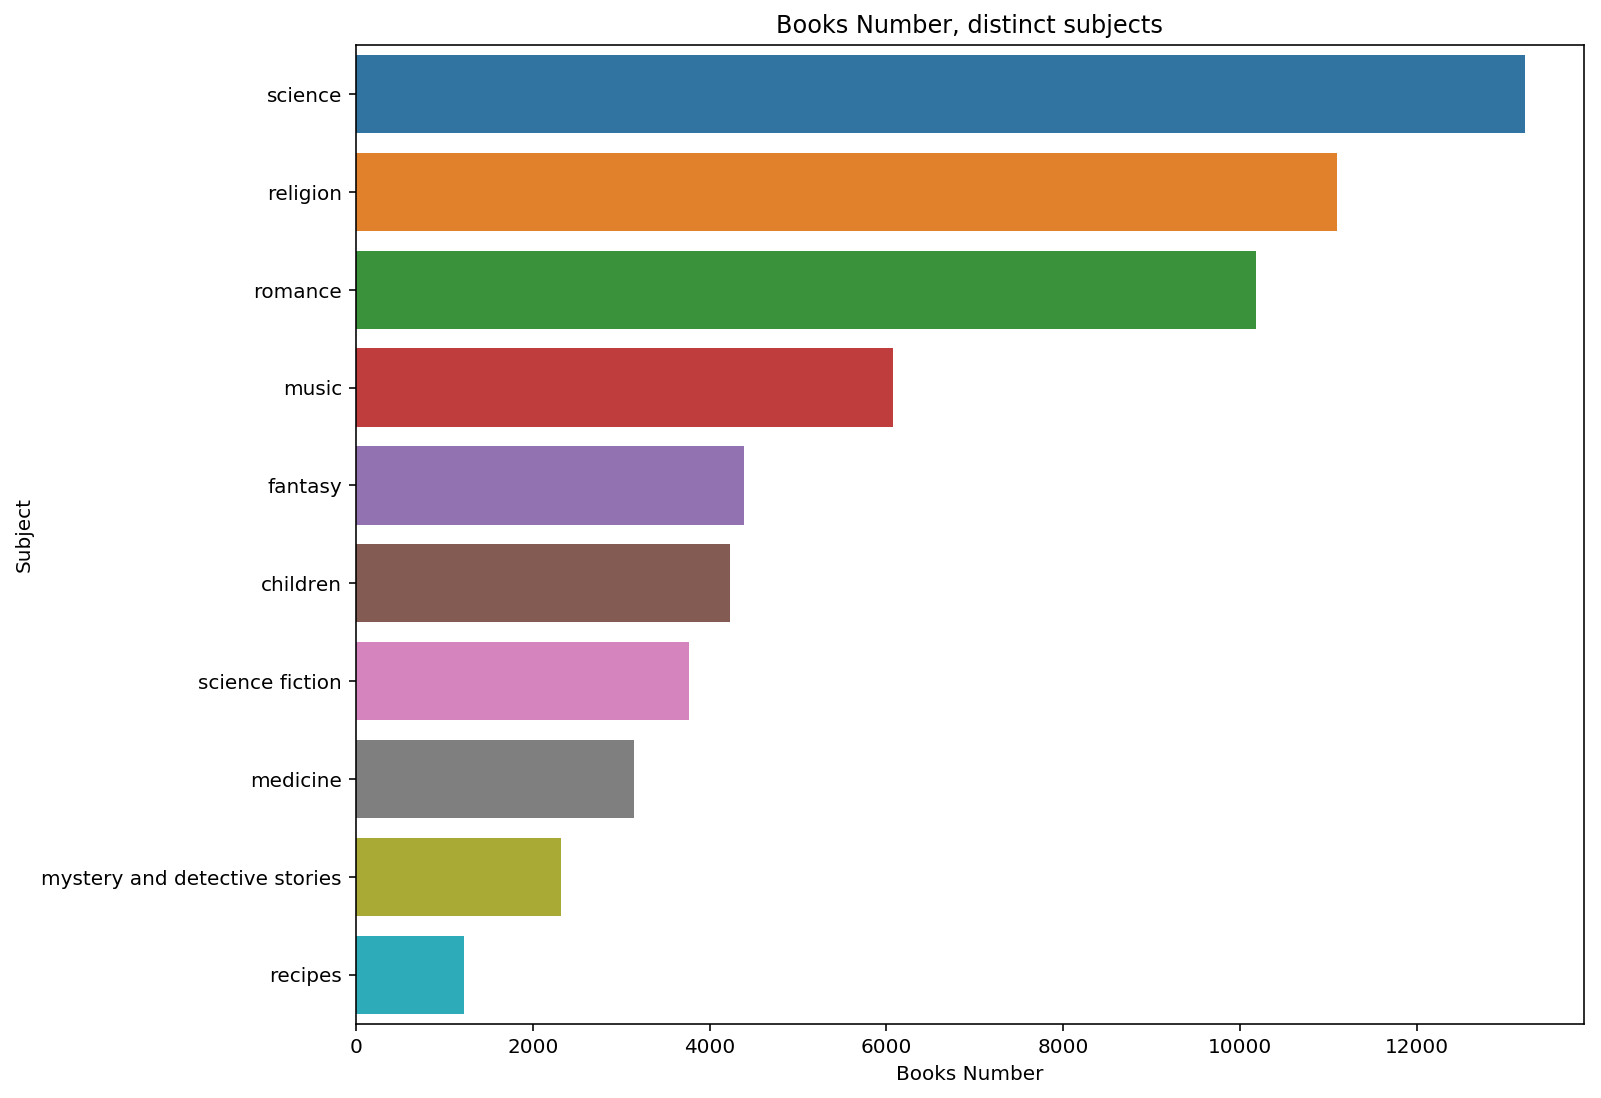

In [44]:
df_bar_plot = books[subj_list].sum().reset_index()
df_bar_plot.rename(columns={'index':'Subject', 0:'Books Number'}, inplace= True)
df_bar_plot.sort_values(by = ['Books Number'], ascending= False, inplace= True)
b_len = sns.barplot(x='Books Number',y='Subject',data=df_bar_plot)
b_len.set_title('Books Number, distinct subjects')
fig = b_len.get_figure()
fig.savefig('Books Number, distinct subjects', dpi = 300, bbox_inches='tight')
print();

Классы книг неравновесны. Кроме этого перед нами стоит мультиклассовая задача, 
необходимо определить принадлежность нескольким классам

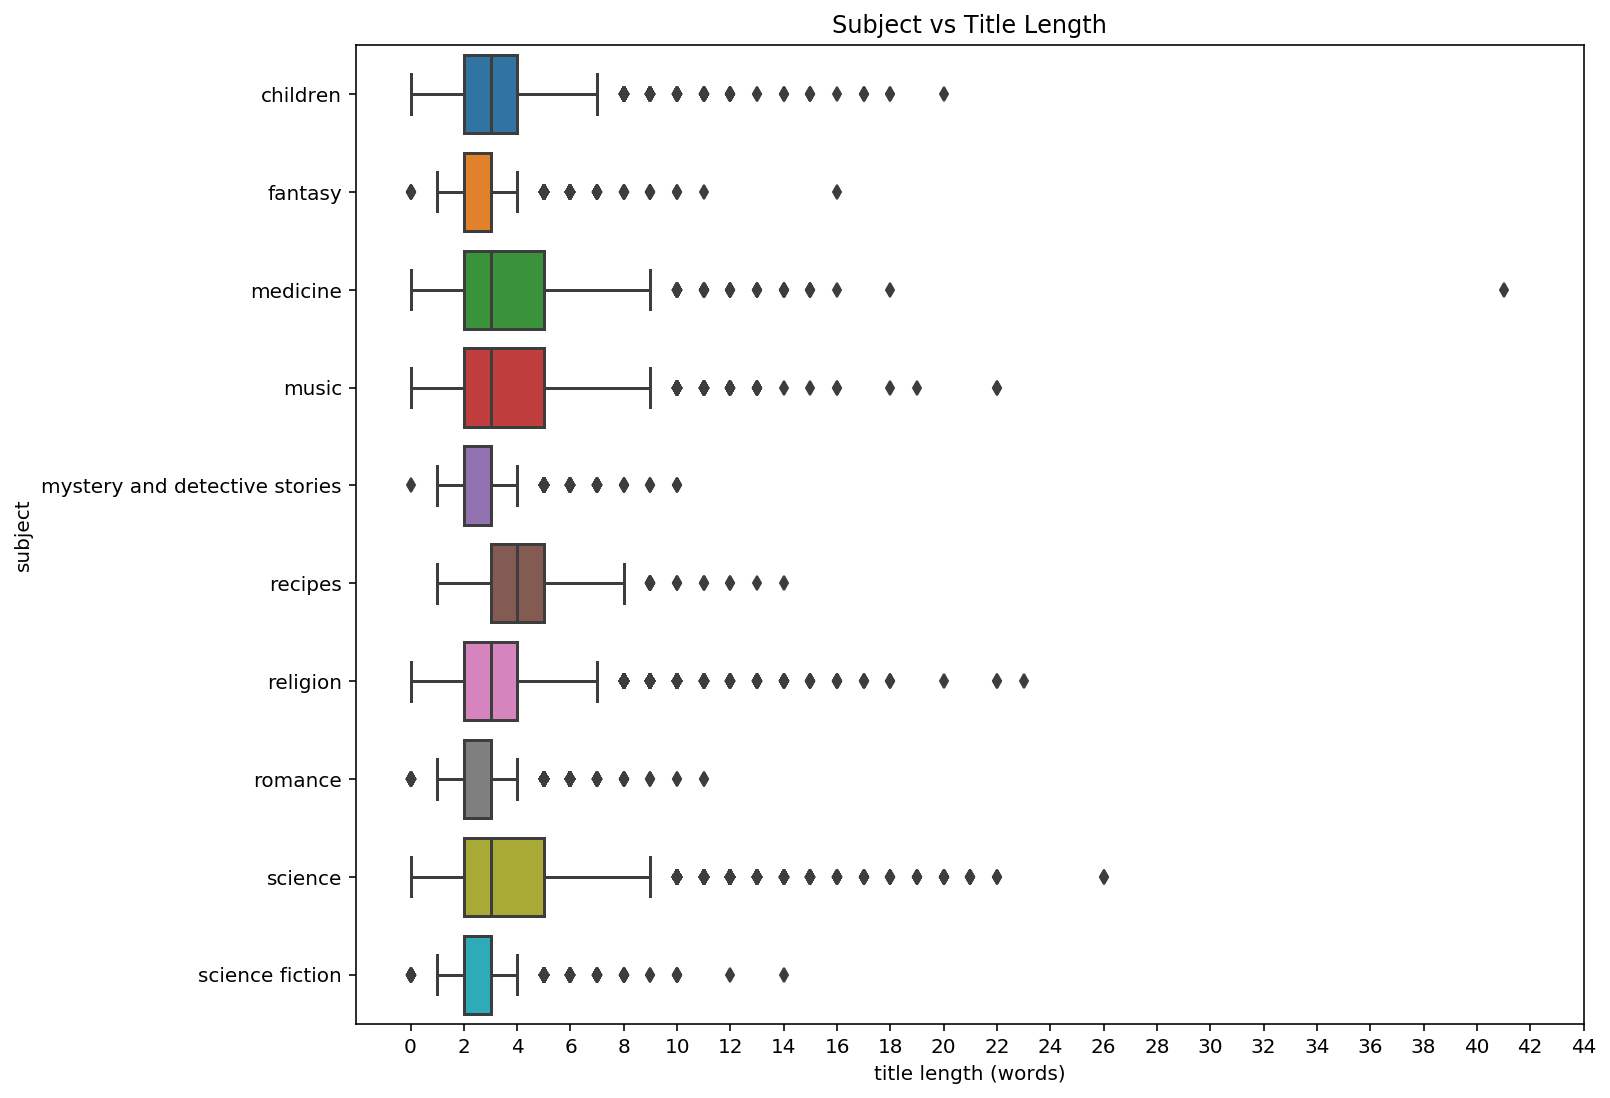

In [50]:
# изобразим график длины слов по всем тематикам, тут будет удобен boxplot
subj_len_plot = pd.DataFrame(columns=['subject', 'title length (words)'])
for i in subj_list:
    temp = books[[i+'txt','title_len']][books[i] == 1]
    temp.rename(index=str, columns={i+'txt': 'subject', 'title_len': 'title length (words)'}, inplace= True)
    temp.head()
    subj_len_plot = pd.concat([subj_len_plot,temp],  ignore_index=True)
sns_plot = sns.boxplot(x='title length (words)', y='subject',data=subj_len_plot)
sns_plot.set_title('Subject vs Title Length')
sns_plot.set_xticks(list(range(0, 45, 2)))
fig = sns_plot.get_figure()
fig.savefig("subject vs title length.png", dpi = 300, bbox_inches='tight')
print();    

Название книг в основном состоит из 2-6 слов. Причем, взаимосвязь между ними будет улавливаться очень слабо.
В этой задаче очень помогут эмбеддинги word2vec на заранее обученном корпусе.

In [ ]:
# создадим коллекцию wordclouds по всем темам, это покажет наиболее значимые слова для каждой темы.
for i in subj_list:
    subj_df = books.words[books[i] == 1]
    subj_word = str()
    for key, value in subj_df.items():
        for w in value:
            subj_word  = subj_word + w +' '
            
    wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white',
                          width=5000, height=3000, colormap = 'ocean_r').generate(subj_word)
    fig = plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    fig.savefig(i+'.png', dpi= 300)

Можно предполагать, что более активные слова и их эмбеддинги и будут решающими в определении темы книги